In [ ]:
# Import necessary libraries
import json
import pandas as pd

In [ ]:
!pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
path = kagglehub.dataset_download("yelp-dataset/yelp-dataset")

print("Path to dataset files:", path)

100%|██████████| 4.07G/4.07G [00:40<00:00, 107MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/yelp-dataset/yelp-dataset/versions/4


### Prepare Restaurant Data

In [ ]:
# Generator function for businesses
def load_businesses(file_path):
    with open(file_path, 'r') as data_file:
        for line in data_file:
            business_info = json.loads(line)
            yield business_info

business_raw = pd.DataFrame(load_businesses("/root/.cache/kagglehub/datasets/yelp-dataset/yelp-dataset/versions/4/yelp_academic_dataset_business.json"))

In [ ]:
# Preview business data
business_raw.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [ ]:
PA_mask = business_raw['state'] == 'PA'
restaurants_mask = business_raw['categories'].notna() & business_raw['categories'].str.contains('Restaurants')

In [ ]:
restaurants = business_raw[PA_mask & restaurants_mask]
restaurants.reset_index(drop=True, inplace=True)
restaurants.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
1,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-..."
2,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.5,205,1,"{'NoiseLevel': 'u'quiet'', 'GoodForMeal': '{'d...","Korean, Restaurants","{'Monday': '11:30-20:30', 'Tuesday': '11:30-20..."
3,QdN72BWoyFypdGJhhI5r7g,Bar One,767 S 9th St,Philadelphia,PA,19147,39.939825,-75.157447,4.0,65,0,"{'Smoking': 'u'no'', 'NoiseLevel': 'u'average'...","Cocktail Bars, Bars, Italian, Nightlife, Resta...","{'Monday': '16:0-0:0', 'Tuesday': '16:0-0:0', ..."
4,Mjboz24M9NlBeiOJKLEd_Q,DeSandro on Main,4105 Main St,Philadelphia,PA,19127,40.022466,-75.218314,3.0,41,0,"{'RestaurantsReservations': 'False', 'Caters':...","Pizza, Restaurants, Salad, Soup","{'Tuesday': '17:0-21:30', 'Wednesday': '17:0-1..."


In [ ]:
restaurants.shape

(12641, 14)

In [ ]:
# restaurants['city'].unique()

In [ ]:
# Maintain set of restaurant business_ids to prune reviews
restaurant_ids = set(restaurants['business_id'])

### Prepare Restaurant Reviews

In [ ]:
# Generator function for filtered reviews
def load_filtered_reviews(file_path, restaurant_ids):
    with open(file_path, 'r') as data_file:
        for line in data_file:
            review_info = json.loads(line)
            if review_info['business_id'] in restaurant_ids:
                yield review_info

# Convert the filtered data into a DataFrame
review_raw = pd.DataFrame(load_filtered_reviews('/root/.cache/kagglehub/datasets/yelp-dataset/yelp-dataset/versions/4/yelp_academic_dataset_review.json', restaurant_ids))

In [ ]:
# Preview review data
review_raw.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
2,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31
3,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5.0,2,0,0,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16
4,8JFGBuHMoiNDyfcxuWNtrA,smOvOajNG0lS4Pq7d8g4JQ,RZtGWDLCAtuipwaZ-UfjmQ,4.0,0,0,0,Good food--loved the gnocchi with marinara\nth...,2009-10-14 19:57:14


In [ ]:
review_raw.shape

(1100250, 9)

In [ ]:
review_raw['date'] = pd.to_datetime(review_raw['date']).dt.date

In [ ]:
review_raw.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07
1,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04
2,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,2015-09-23
3,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5.0,2,0,0,Amazingly amazing wings and homemade bleu chee...,2015-08-07
4,8JFGBuHMoiNDyfcxuWNtrA,smOvOajNG0lS4Pq7d8g4JQ,RZtGWDLCAtuipwaZ-UfjmQ,4.0,0,0,0,Good food--loved the gnocchi with marinara\nth...,2009-10-14


In [ ]:
text_column = review_raw['text']
text_column.head()

,text
0,"If you decide to eat here, just be aware it is..."
1,"Wow! Yummy, different, delicious. Our favo..."
2,I am a long term frequent customer of this est...
3,Amazingly amazing wings and homemade bleu chee...
4,Good food--loved the gnocchi with marinara\nth...


##TD-IDF Vector Time

In [ ]:
#TODO: Figure out TD-IDF Vectorization with sklearn with YT

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer()
response =

In [ ]:
# Maintain set of user_ids to prune user data
user_ids = set(review_raw['user_id'])

#Review EDA

array([[<Axes: title={'center': 'stars'}>]], dtype=object)

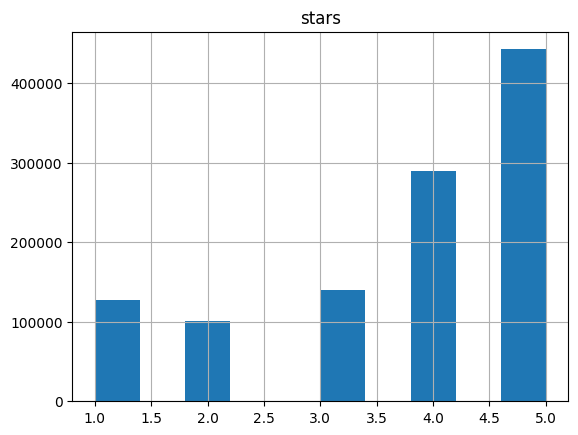

In [ ]:
review_raw.hist(column='stars')

In [ ]:
review_raw['date']

,date
0,2018-07-07
1,2015-01-04
2,2015-09-23
3,2015-08-07
4,2009-10-14
...,...
1100245,2012-10-13
1100246,2013-07-25
1100247,2014-11-03
1100248,2018-03-13


In [ ]:
#TODO: Fix the datetime histogram distribution

In [ ]:
review_counts_by_date = review_raw['date'].value_counts()
print(review_counts_by_date)

date
2019-02-17    624
2017-10-08    579
2018-03-04    569
2018-05-13    561
2017-02-20    560
             ... 
2007-01-09      1
2006-01-26      1
2006-06-21      1
2006-02-26      1
2006-12-11      1
Name: count, Length: 5794, dtype: int64


<Axes: xlabel='date'>

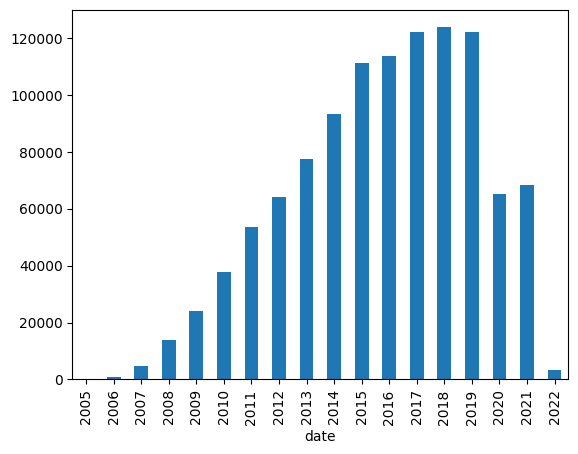

In [ ]:
review_raw['date'] = pd.to_datetime(review_raw['date'])
review_raw['review_id'].groupby([review_raw["date"].dt.year]).count().plot(kind="bar")

<Axes: xlabel='date'>

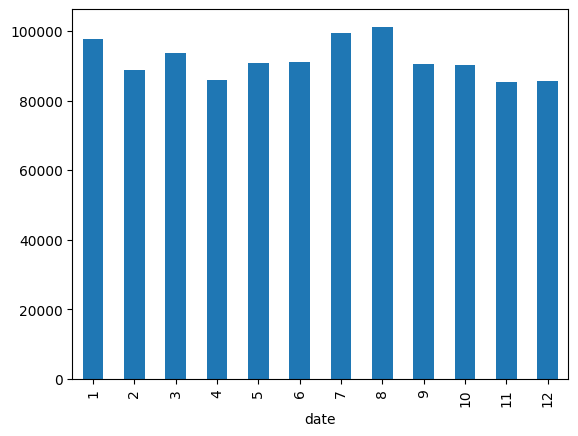

In [ ]:
review_raw['date'] = pd.to_datetime(review_raw['date'])
review_raw['review_id'].groupby([review_raw["date"].dt.month]).count().plot(kind="bar")

### Prepare Users

In [ ]:
# Generator function for filtered users
def load_filtered_users(file_path, user_ids):
    with open(file_path, 'r') as data_file:
        for line in data_file:
            user_info = json.loads(line)
            if user_info['user_id'] in user_ids:
                yield user_info

# Convert the filtered data into a DataFrame
user_raw = pd.DataFrame(load_filtered_users('./yelp-dataset/yelp_academic_dataset_user.json', user_ids))

In [ ]:
user_raw.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,q_QQ5kBBwlCcbL1s4NVK3g,Jane,1221,2005-03-14 20:26:35,14953,9940,11211,"2006,2007,2008,2009,2010,2011,2012,2013,2014","xBDpTUbai0DXrvxCe3X16Q, 7GPNBO496aecrjJfW6UWtg...",1357,...,163,191,361,147,1212,5696,2543,2543,815,323
3,AUi8MPWJ0mLkMfwbui27lg,John,109,2010-01-07 18:32:04,154,20,23,,"gy5fWeSv3Gamuq9Ox4MV4g, lMr3LWU6kPFLTmCpDkACxg...",4,...,0,0,0,0,1,6,3,3,0,0
4,1McG5Rn_UDkmlkZOrsdptg,Teresa,7,2009-05-26 16:11:11,18,3,13,,"piejMEdRkGB7-1aL4lL5NQ, X0zFOU6iG95-feQKOXkgrA...",1,...,0,0,0,0,1,0,2,2,0,0


In [ ]:
user_raw.shape

(312426, 22)

In [ ]:
user_raw.columns

Index(['user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny',
       'cool', 'elite', 'friends', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos'],
      dtype='object')